#### Imports

In [1]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
import time
from transformers import DistilBertTokenizer, DistilBertModel
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from hyperopt import hp
from scipy.stats import kruskal
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))


GPU Available: False
Number of GPU Available: 0


## Load the dataset

### IMDB dataset

In [3]:
imdb = load_dataset("imdb")

Found cached dataset imdb (C:/Users/rgolan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# embed the sentences - take 500 negative samples and 500 positive samples. Note that in the IMDB set, the negative examples are in the first half of the dataset (0-12500)
# the positive examples are in the second half
num_sentences_to_embed = 1000
neg_examples_idx = list(np.random.randint(low=0,high=12500,size=num_sentences_to_embed//2))
pos_examples_idx = list(np.random.randint(low=12500,high=25000,size=num_sentences_to_embed//2))
examples_to_embed_idx = neg_examples_idx + pos_examples_idx

In [5]:
train_sentences = [imdb['train'][int(i)]['text'] for i in examples_to_embed_idx]
train_labels = [imdb['train'][int(i)]['label'] for i in examples_to_embed_idx]
print(f"there are {len(train_sentences)} sentences in the training set")

there are 1000 sentences in the training set


## Get embeddings

#### BERT embeddings

In [13]:
# initialize a tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [14]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
embed_dim = bert_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")
bert_model.config.output_hidden_states

embedding dimension = 768


False

In [16]:
bert_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bert_tokenizer(train_sentences[i], padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        output = bert_model(**input, output_hidden_states=True)
    # as the sentence embedding we're taking the hidden state corresponding to the [CLS] token
    bert_embeddings[i,:] = output.last_hidden_state[:,0,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 45.7897 seconds passed 


processed 201 sentences
so far, 89.3573 seconds passed 


processed 301 sentences
so far, 135.1618 seconds passed 


processed 401 sentences
so far, 183.8605 seconds passed 


processed 501 sentences
so far, 230.6930 seconds passed 


processed 601 sentences
so far, 274.4580 seconds passed 


processed 701 sentences
so far, 319.8834 seconds passed 


processed 801 sentences
so far, 362.6773 seconds passed 


processed 901 sentences
so far, 408.3203 seconds passed 




In [17]:
print(f"bert embeddings shape = {bert_embeddings.shape}")

bert embeddings shape = (1000, 768)


#### GPT2 embeddings

In [6]:
from transformers import AutoTokenizer, GPT2Model
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2_model = GPT2Model.from_pretrained("gpt2")

In [7]:
embed_dim = gpt2_model.config.n_embd
print(f"embedding dimension = {embed_dim}")
gpt2_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = gpt2_tokenizer(train_sentences[i], truncation=True, max_length=1024,return_tensors="pt")
    with torch.no_grad():
        output = gpt2_model(**input)
    gpt2_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


embedding dimension = 768
processed 101 sentences
so far, 66.7559 seconds passed 


processed 201 sentences
so far, 125.8900 seconds passed 


processed 301 sentences
so far, 196.7547 seconds passed 


processed 401 sentences
so far, 271.1222 seconds passed 


processed 501 sentences
so far, 344.7378 seconds passed 


processed 601 sentences
so far, 428.6384 seconds passed 


processed 701 sentences
so far, 509.9998 seconds passed 


processed 801 sentences
so far, 584.1705 seconds passed 


processed 901 sentences
so far, 657.2245 seconds passed 




In [52]:
input = gpt2_tokenizer("Hello, my dog is cute", return_tensors="pt")
print(input.input_ids)

tensor([[15496,    11,   616,  3290,   318, 13779]])


In [55]:
gpt2_tokenizer.convert_ids_to_tokens(11)


','

In [60]:
from transformers import AutoTokenizer, XLMModel, AlbertModel

xxx_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
xxx_model = AlbertModel.from_pretrained("albert-base-v2")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
embed_dim = xxx_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")
input = xxx_tokenizer("Hello, my dog is cute", return_tensors="pt")
output = xxx_model(**input)

last_hidden_states = output.last_hidden_state

embedding dimension = 768


In [64]:
xxx_tokenizer.convert_ids_to_tokens(2)

'[CLS]'

In [63]:
input.input_ids

tensor([[    2, 10975,    15,    51,  1952,    25, 10901,     3]])

In [38]:
last_hidden_states.shape

torch.Size([1, 8, 2048])

In [44]:
from transformers import AutoTokenizer, BartModel

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartModel.from_pretrained("facebook/bart-base")

inputs = bart_tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = bart_model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [45]:
inputs.input_ids

tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]])

In [51]:
last_hidden_states.shape

torch.Size([1, 8, 768])

In [49]:
bart_tokenizer.convert_ids_to_tokens(31414)

'Hello'

In [50]:
print(bart_model)

BartModel(
  (shared): Embedding(50265, 768, padding_idx=1)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50265, 768, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0-5): 6 x BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding): La

## Classification of embedded test

In [18]:
X = np.concatenate((bert_embeddings,gpt2_embeddings),axis=1)
#X = gpt2_embeddings.copy()
print(f"X shape = {X.shape}")

X shape = (1000, 1536)


In [19]:
y = np.array(train_labels)

In [20]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X, y_train=y, iterations=50)
best_params = hyper_opt.run()
print(best_params)

100%|██████████| 50/50 [00:59<00:00,  1.18s/trial, best loss: -0.85] 
{'C': 0.11066135296961566, 'degree': 1, 'kernel': 'linear'}


Measuring accuracy with 2 classes,  5 training examples per class
---------------------------------------------------------------
In classifier with feature selector FeatureSelectionDiversityPursuitAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionOneVsAllAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionDiversityPursuitAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionOneVsAllAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionDiversityPursuitAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSel

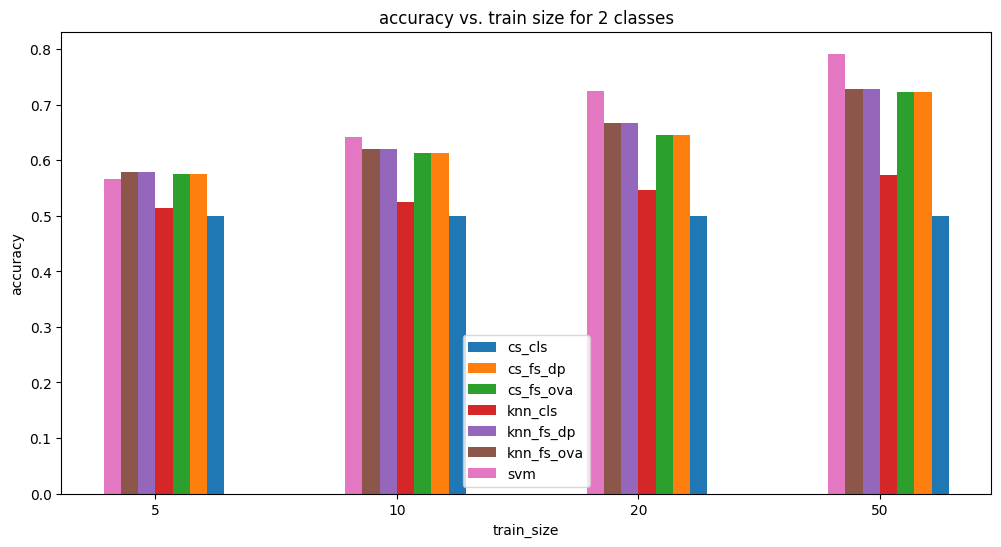

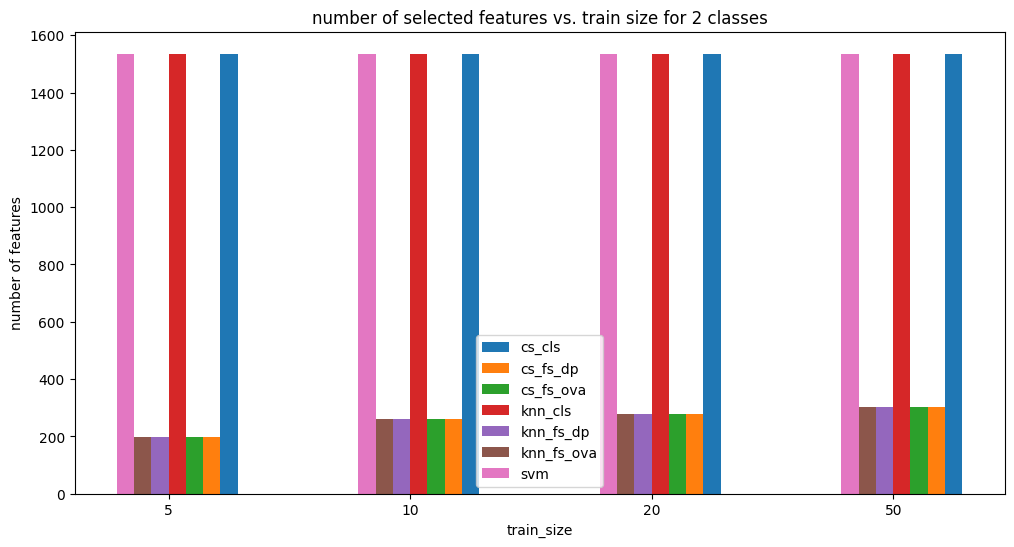

In [21]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova
gamma = 0.2
train_sizes = [5,10,20,50]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
num_experiments = 50
num_splits = 5
# define possible sizes for the train set (number of train examples per class)
num_classes = 2
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    print(f"Measuring accuracy with {num_classes} classes,  {train_sizes[i]} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizes[i]*num_classes, stratify=y)
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers,
                                                                                              X_train=X_train,
                                                                                              y_train=y_train,
                                                                                              X_test=X_test,
                                                                                              y_test=y_test)
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies[l,i,:])}, std accuracy is {np.std(accuracies[l,i,:])}")
    print("\n\n\n")

bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')

## Text classification using GPTNeo embeddings

In [63]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.pad_token)
tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

<|endoftext|>


50256

In [67]:
from transformers import GPTNeoForSequenceClassification, GPTNeoModel
gpt_neo_model = GPTNeoModel.from_pretrained("EleutherAI/gpt-neo-1.3B")
gpt_neo_model.config.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

Some weights of GPTNeoModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-1.3B and are newly initialized: ['transformer.h.19.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.13.attn.attention.bias', 'transformer.h.21.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.15.attn.attention.bias', 'transformer.h.7.attn.attention.bias', 'transformer.h.1.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.17.attn.attention.bias', 'transformer.h.23.attn.attention.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION

def get_features(name):
    def hook(model, input, output):
        features[name] = input[0].detach()
    return hook

#model.transformer.ln_f.register_forward_hook(get_features('cls_input'))
gpt_neo_model.score.register_forward_hook(get_features('cls_input'))

In [66]:
#sentences = ["Hello, my dog is really disgusting", 'This is awful!!']
sentences = ["Hello, my dog is really disgusting"]
tic = time.perf_counter()
inputs = tokenizer(sentences, padding=True, truncation=True, max_length=256, return_tensors="pt")
with torch.no_grad():
    logits = gpt_neo_model(**inputs).logits
toc = time.perf_counter()
print(inputs)
print(f"tokenization and inference in {toc - tic:0.4f} seconds")
predicted_class_id = logits
print(predicted_class_id)

{'input_ids': tensor([[15496,    11,   616,  3290,   318,  1107, 23374]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
tokenization and inference in 1.0834 seconds
tensor([[3.0147, 3.3332]])


In [38]:
model.config

GPTNeoConfig {
  "_name_or_path": "EleutherAI/gpt-neo-1.3B",
  "activation_function": "gelu_new",
  "architectures": [
    "GPTNeoForCausalLM"
  ],
  "attention_dropout": 0,
  "attention_layers": [
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local"
  ],
  "attention_types": [
    [
      [
        "global",
        "local"
      ],
      12
    ]
  ],
  "bos_token_id": 50256,
  "embed_dropout": 0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": null,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neo",
  "num_heads": 16,
  "num_layers": 24,
  "resid_dropout": 0,
  "summary_activation": null,
  

In [58]:
features['cls_input'].shape

torch.Size([2, 7, 2048])

In [39]:
print(model)

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
     

In [14]:
from transformers import AutoTokenizer, GPTNeoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
model = GPTNeoModel.from_pretrained("EleutherAI/gpt-neo-1.3B")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of GPTNeoModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-1.3B and are newly initialized: ['transformer.h.19.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.13.attn.attention.bias', 'transformer.h.21.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.15.attn.attention.bias', 'transformer.h.7.attn.attention.bias', 'transformer.h.1.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.17.attn.attention.bias', 'transformer.h.23.attn.attention.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
inputs

{'input_ids': tensor([[15496,    11,   616,  3290,   318, 13779]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [15]:
last_hidden_states.shape

torch.Size([1, 6, 2048])